In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split


In [2]:
image_folder = '/kaggle/input/my-dataset-with-labels/Forest Segmented/images'
mask_folder = '/kaggle/input/my-dataset-with-labels/Forest Segmented/masks'
meta_data_path = '/kaggle/input/my-dataset-with-labels/Forest Segmented/meta_data_with_labels_255_40.csv'
# Load metadata
meta_data = pd.read_csv(meta_data_path)
meta_data.head()

,image,mask,label
0,10452_sat_08.jpg,10452_mask_08.jpg,deforested
1,10452_sat_18.jpg,10452_mask_18.jpg,deforested
2,111335_sat_00.jpg,111335_mask_00.jpg,forested
3,111335_sat_01.jpg,111335_mask_01.jpg,forested
4,111335_sat_02.jpg,111335_mask_02.jpg,forested


In [ ]:
# Parameters
img_height, img_width = 256, 256  
batch_size = 16

In [4]:
# Preprocess images and masks
def load_data(image_folder, mask_folder, meta_data, img_height, img_width):
    images = []
    masks = []
    
    for idx, row in meta_data.iterrows():
        img_path = os.path.join(image_folder, row['image'])
        mask_path = os.path.join(mask_folder, row['mask'])
        
        image = load_img(img_path, target_size=(img_height, img_width))
        mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
        
        images.append(img_to_array(image) / 255.0)
        masks.append(img_to_array(mask) / 255.0)
    
    return np.array(images), np.array(masks)

In [5]:
# Load dataset
images, masks = load_data(image_folder, mask_folder, meta_data, img_height, img_width)

In [6]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [7]:
# Data augmentation
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

#  train_generator function
def create_data_generator(images, masks, batch_size):
    image_generator = image_datagen.flow(
        images,
        batch_size=batch_size,
        seed=42
    )
    mask_generator = mask_datagen.flow(
        masks,
        batch_size=batch_size,
        seed=42
    )
    
    # Combine generators into one that yields both images and masks
    while True:
        X_batch = next(image_generator)
        y_batch = next(mask_generator)
        yield X_batch, y_batch

# Set up data generator for training
train_generator = create_data_generator(X_train, y_train, batch_size)



In [8]:
# Define U-Net model
def unet_model(input_size=(img_height, img_width, 3)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = concatenate([u2, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = concatenate([u1, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build model
model = unet_model()


# Train model with data augmentation
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, y_val),
    epochs=40
)


Epoch 1/40


I0000 00:00:1731129839.018540      93 service.cc:145] XLA service 0x7c87f40061e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731129839.018601      93 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731129860.223747      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


255/255 ━━━━━━━━━━━━━━━━━━━━ 127s 402ms/step - accuracy: 0.6223 - loss: 0.6384 - val_accuracy: 0.7301 - val_loss: 0.5618
Epoch 2/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 80s 278ms/step - accuracy: 0.7170 - loss: 0.5577 - val_accuracy: 0.7494 - val_loss: 0.5315
Epoch 3/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 71s 278ms/step - accuracy: 0.7398 - loss: 0.5234 - val_accuracy: 0.7432 - val_loss: 0.5408
Epoch 4/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 69s 273ms/step - accuracy: 0.7449 - loss: 0.5135 - val_accuracy: 0.7319 - val_loss: 0.5546
Epoch 5/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 67s 265ms/step - accuracy: 0.7377 - loss: 0.5250 - val_accuracy: 0.7611 - val_loss: 0.5016
Epoch 6/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 67s 264ms/step - accuracy: 0.7561 - loss: 0.4954 - val_accuracy: 0.7433 - val_loss: 0.5310
Epoch 7/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 68s 265ms/step - accuracy: 0.7599 - loss: 0.4930 - val_accuracy: 0.7711 - val_loss: 0.4936
Epoch 8/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 68s 266ms/step - accuracy: 0.7501 - loss: 0.5035 - va

In [9]:

# Save model
model.save('forest_segmentation_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


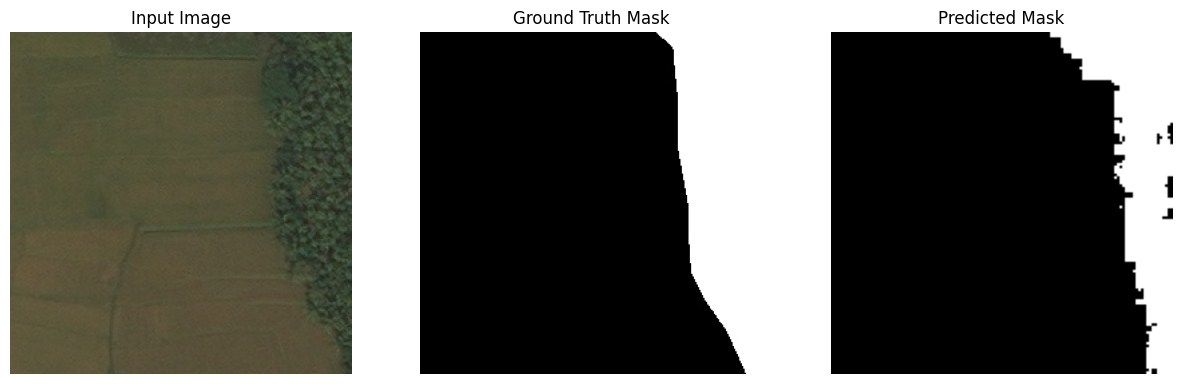

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


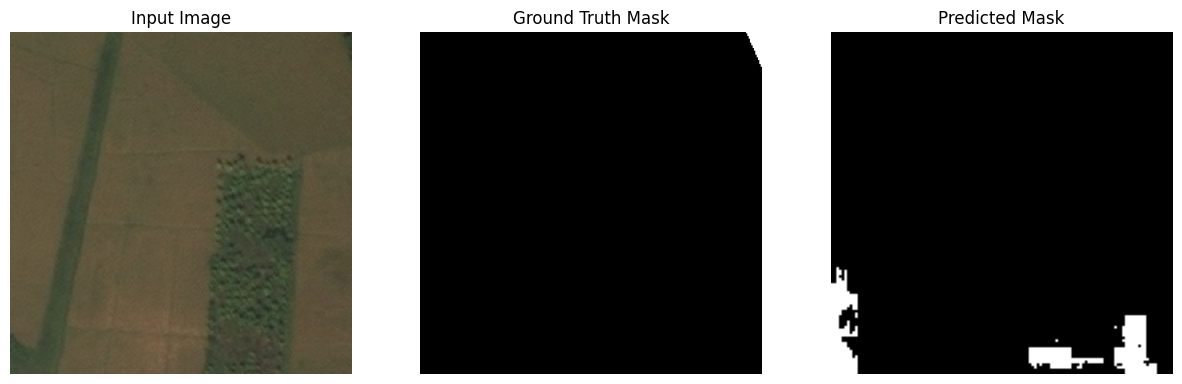

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


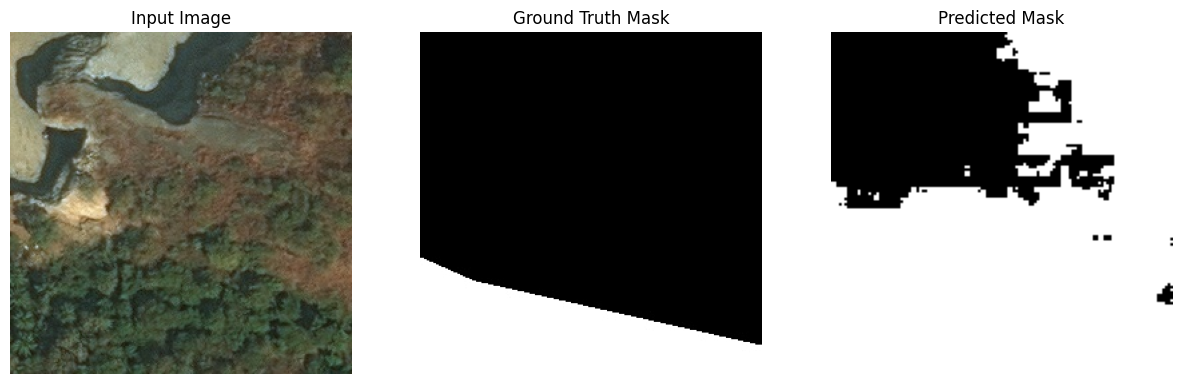

In [13]:
import matplotlib.pyplot as plt

# Load and preprocess input image for prediction
def preprocess_image(image_path, img_height=128, img_width=128):
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Predict mask for a given image
def predict_mask(model, image_path, img_height=128, img_width=128):
    image = preprocess_image(image_path, img_height, img_width)
    predicted_mask = model.predict(image)
    
    # Threshold the mask for binary output
    predicted_mask = (predicted_mask[0, :, :, 0] > 0.5).astype(np.uint8)
    return predicted_mask

# Display input image, ground truth mask, and predicted mask
def display_results(image_path, predicted_mask, mask_path=None):
    image = load_img(image_path)
    plt.figure(figsize=(15, 5))

    # Display input image
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis("off")

    # Display ground truth mask if available
    if mask_path:
        true_mask = load_img(mask_path, color_mode="grayscale")
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(true_mask, cmap="gray")
        plt.axis("off")

    # Display predicted mask
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap="gray")
    plt.axis("off")

    plt.show()

# Example usage
image_path = '/kaggle/input/my-dataset-with-labels/Forest Segmented/images/10452_sat_08.jpg'
mask_path = '/kaggle/input/my-dataset-with-labels/Forest Segmented/masks/10452_mask_08.jpg'  # Optional, if you want to compare

# Predict and display
predicted_mask = predict_mask(model, image_path)
display_results(image_path, predicted_mask, mask_path)

# Example usage
image_path = '/kaggle/input/my-dataset-with-labels/Forest Segmented/images/10452_sat_18.jpg'
mask_path = '/kaggle/input/my-dataset-with-labels/Forest Segmented/masks/10452_mask_18.jpg'  # Optional, if you want to compare

# Predict and display
predicted_mask = predict_mask(model, image_path)
display_results(image_path, predicted_mask, mask_path)

# Example usage
image_path = '/kaggle/input/my-dataset-with-labels/Forest Segmented/images/111335_sat_55.jpg'
mask_path = '/kaggle/input/my-dataset-with-labels/Forest Segmented/masks/111335_mask_55.jpg'  # Optional, if you want to compare

# Predict and display
predicted_mask = predict_mask(model, image_path)
display_results(image_path, predicted_mask, mask_path)


In [11]:
#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)

print("IoU socre is: ", round(iou_score,2))

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step
IoU socre is:  0.74
